In [1]:
import numpy as np
from scipy.stats import pearsonr
import datetime
import pandas as pd
from scipy.stats import linregress
from netCDF4 import Dataset
from scipy.interpolate import griddata
import os
import pickle
import itertools
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
from regrid import regrid
import seaborn as sns
import cartopy
import numpy.ma as ma
import tqdm
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/phd/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [2]:
all_fbs = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/freeboard_daily_interpolated/CS2_CPOM_full.nc')['Radar Freeboard'])[3560:3773] # CS2_CPOM interpolated freeboard data
all_snow = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/data/SMLG_snod_EASE.nc')['Snow Depth'])[3560:3773] # SM-LG snow depth data

days = np.arange(0,len(all_fbs))
one = [] ; two = [] ; three = []
sd1 = [] ; sd2 = [] ; sd3 = []

for fb in all_fbs:
    one.append(fb[205,145])
    two.append(fb[159,251])
    three.append(fb[226,151])
    
for sd in all_snow:
    sd1.append(sd[205,145])
    sd2.append(sd[159,251])
    sd3.append(sd[226,151])

In [3]:
# rms
four = [] ; five = [] ; six = [] ; sd4 = [] ; sd5 = [] ; sd6 = []
# uas
seven = [] ; eight = [] ; nine = [] ; sd7 = [] ; sd8 = [] ; sd9 = []
# sas
ten = [] ; eleven = [] ; twelve = [] ; sd10 = [] ; sd11 = [] ; sd12 = []

T1 = 15 ## for 31-day running mean put T=15
T2 = 4 ## for 9-day running mean of anomalies put T=4

freeb_anoms_big = np.full(all_fbs.shape,np.nan)
snow_anoms_big = np.full(all_snow.shape,np.nan)

for day in tqdm.trange(all_fbs.shape[0]):
    
    # 31-day running mean for each grid cell in time dimension
    
    freeb_31day = np.nanmean(all_fbs[day-T1:day+T1],axis=0)
    snow_31day = np.nanmean(all_snow[day-T1:day+T1],axis=0)
    four.append(freeb_31day[205,145])
    five.append(freeb_31day[159,251])
    six.append(freeb_31day[226,151])
    sd4.append(snow_31day[205,145])
    sd5.append(snow_31day[159,251])
    sd6.append(snow_31day[226,151])

    
    # now make anomalies from 31 day means
    
    freeb_anoms_big[day] = all_fbs[day] - freeb_31day
    snow_anoms_big[day] = all_snow[day] - snow_31day
    seven.append(freeb_anoms_big[day,205,145])
    eight.append(freeb_anoms_big[day,159,251])
    nine.append(freeb_anoms_big[day,226,151])
    sd7.append(snow_anoms_big[day,205,145])
    sd8.append(snow_anoms_big[day,159,251])
    sd9.append(snow_anoms_big[day,226,151])

fb_running_mean_anoms = np.full(all_fbs.shape,np.nan)
sd_running_mean_anoms = np.full(all_snow.shape,np.nan)

# # 9 day mean of anoms for each grid cell in time dimension
for day in tqdm.trange(all_fbs.shape[0]):
    
    fb_running_mean_anoms[day] = np.nanmean(freeb_anoms_big[day-T2:day+T2],axis=0) 
    sd_running_mean_anoms[day] = np.nanmean(snow_anoms_big[day-T2:day+T2],axis=0) 
    ten.append(fb_running_mean_anoms[day,205,145])
    eleven.append(fb_running_mean_anoms[day,159,251])
    twelve.append(fb_running_mean_anoms[day,226,151])
    
    sd10.append(sd_running_mean_anoms[day,205,145])
    sd11.append(sd_running_mean_anoms[day,159,251])
    sd12.append(sd_running_mean_anoms[day,226,151])

100%|████████████████████████████████████████| 213/213 [00:01<00:00, 191.45it/s]


In [4]:
# print coordinates of the three grid cells
lats = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/lat_25km.npy')
lons = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/lon_25km.npy')

print(lats[205,145],lons[205,145])
print(lats[159,251],lons[159,251])
print(lats[226,151],lons[226,151])

80.36061024964047 -125.53767779197437
73.36483994931511 73.52311860631204
77.80388000215154 -147.77124256490143


### plot figure

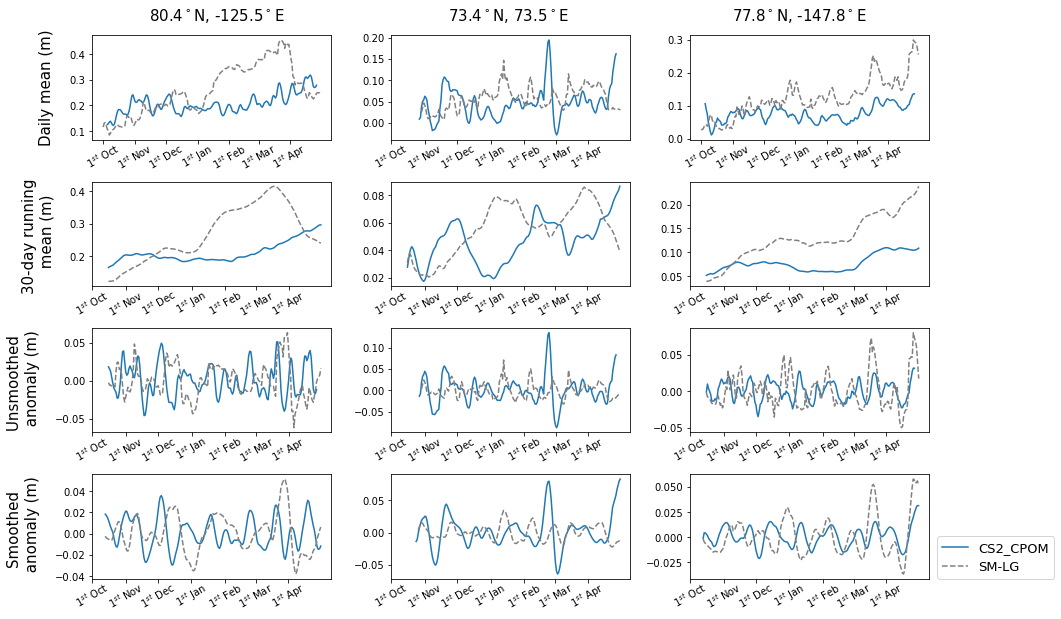

In [5]:
fb_steps = [one,two,three,four,five,six,seven,eight,nine,ten,eleven,twelve]
sd_steps = [sd1,sd2,sd3,sd4,sd5,sd6,sd7,sd8,sd9,sd10,sd11,sd12]
fig = plt.figure(figsize=(15,10))
spec = gridspec.GridSpec(ncols=3, nrows=4, wspace=0.25, hspace=0.4)
        
for count in np.arange(0,12):
    ax = fig.add_subplot(spec[count])
    ax.plot(days,fb_steps[count],label='CS2_CPOM')
    ax.plot(days,sd_steps[count],color='grey',linestyle='dashed',label='SM-LG')
    ax.set_xticks([0,31,61,92,123,152, 182])
    ax.set_xticklabels(['$1^{st}$ Oct','$1^{st}$ Nov','$1^{st}$ Dec',
                        '$1^{st}$ Jan','$1^{st}$ Feb','$1^{st}$ Mar', '$1^{st}$ Apr'],rotation=30) 
    ax.tick_params('x',pad=-2)
    if count == 11:
        ax.legend(bbox_to_anchor = (1.55, 0.47),fontsize=13)
    if count == 0:
        ax.set_ylabel('Daily mean (m)', fontsize = 15, labelpad=15)
    if count == 3:
        ax.set_ylabel('30-day running \n mean (m)', fontsize = 15, labelpad=15)
    if count == 6:
        ax.set_ylabel('Unsmoothed \n anomaly (m)', fontsize = 15, labelpad=15)
    if count == 9:
        ax.set_ylabel('Smoothed \n anomaly (m)', fontsize = 15, labelpad=15)
        
fig.text(0.24, 0.9, '80.4$^\circ$N, -125.5$^\circ$E', ha='center',fontsize = 15)
fig.text(0.51, 0.9, '73.4$^\circ$N, 73.5$^\circ$E', ha='center',fontsize = 15)
fig.text(0.78, 0.9, '77.8$^\circ$N, -147.8$^\circ$E', ha='center',fontsize = 15)
plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/Snow Interpolated Freeboards/supp_figs/steps.png',bbox_inches = "tight", dpi = 400)